# setup

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

In [ ]:
def lara_graph(X, print_tqdm = True):
    D = distance_matrix(X, X) ** 2
    D[np.diag_indices(D.shape[0])] = 1e6

    n = X.shape[0]
    adjacencia = np.zeros(shape = (n, n))
    if print_tqdm:
      for i in tqdm(range(n-1)):
          for j in range(i+1, n):
              minimo = min(D[i, :] + D[j, :])
              if (D[i, j] <= minimo):
                  adjacencia[i, j] = 1
                  adjacencia[j, i] = 1
    else:
      for i in range(n-1):
          for j in range(i+1, n):
              minimo = min(D[i, :] + D[j, :])
              if (D[i, j] <= minimo):
                  adjacencia[i, j] = 1
                  adjacencia[j, i] = 1
    return adjacencia

In [ ]:
def q_index(X, y, gg):
    scores = []
    for i, row in enumerate(gg):
        vizinhos = np.where(row == 1)[0]
        
        degree = len(vizinhos)
        opposite = 0
        for vizinho in vizinhos:
            opposite += np.exp(-np.linalg.norm(X[i] - X[vizinho])) * np.abs(y[i] - y[vizinho]) / 2
        q = 1 - opposite / degree
        scores.append(q)
    scores = np.array(scores)
    return scores

# normal

In [ ]:
def normal(sd, n):
    mean = (0, 0)
    cov = [[sd, 0], [0, sd]]
    x1 = np.random.multivariate_normal(mean, cov, size = n)
    
    mean = (1, 1)
    cov = [[sd, 0], [0, sd]]
    x2 = np.random.multivariate_normal(mean, cov, size = n)
    
    X = np.concatenate((x1, x2))
    y = np.array([-1] * n + [1] * n)
    
    return X, y

100%|██████████| 499/499 [00:05<00:00, 99.43it/s] 


0.1 0.9702939318176181


100%|██████████| 499/499 [00:05<00:00, 99.62it/s] 


0.5 0.8103186279321515


100%|██████████| 499/499 [00:06<00:00, 76.65it/s] 


1.0 0.7242984816407695


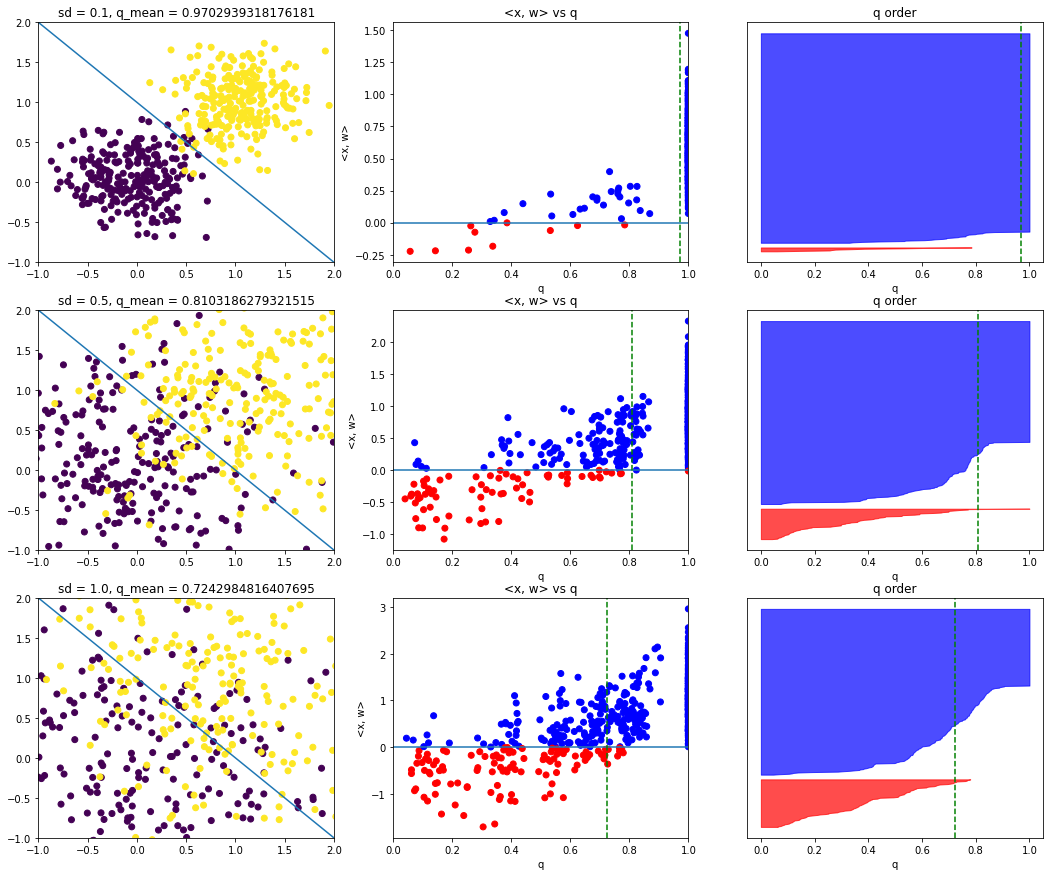

In [ ]:
n = 250
sds = [0.1, 0.5, 1.0]

fig, axis = plt.subplots(len(sds), 3, figsize = (18, 5*len(sds)))

for idx, sd in enumerate(sds):
  # data
  X, y = normal(sd, n)

  # gg
  gg = lara_graph(X)

  # scores = []
  # for i, row in enumerate(gg):
  #     vizinhos = np.where(row == 1)[0]
      
  #     degree = len(vizinhos)
  #     opposite = 0
  #     for vizinho in vizinhos:
  #         opposite += np.exp(-np.linalg.norm(X[i] - X[vizinho])) * np.abs(y[i] - y[vizinho]) / 2
  #     q = 1 - opposite / degree
  #     scores.append(q)
  # scores = np.array(scores)
  scores = q_index(X, y, gg)
  print(sd, np.mean(scores))

  # classificador
  w = [-1, 1, 1]
  w = w / np.linalg.norm(w)

  distances = []
  for i, x in enumerate(X):
      x = np.hstack((1, x))
      d = np.dot(x, w) * np.sign(y[i])
      distances.append(d)
  distances = np.array(distances)
  erro = distances < 0

  # plot
  axis[idx, 0].scatter(X[:, 0], X[:, 1], c = y)
  # axis[idx, 0].axline((0, 1), (1, 0))
  axis[idx, 0].plot([-1, 2], [2, -1])
  axis[idx, 0].set_xlim([-1, 2])
  axis[idx, 0].set_ylim([-1, 2])
  axis[idx, 0].set_title('sd = {}, q_mean = {}'.format(sd, np.mean(scores)));

  log = np.stack((scores, distances)).T
  colors = {0:'blue', 1:'red'}

  axis[idx, 1].scatter(log[:, 0], log[:, 1], c = [colors[e] for e in erro[:]])
  axis[idx, 1].axhline(y = 0)
  axis[idx, 1].axvline(x = np.mean(scores), color = 'green', linestyle = '--')
  axis[idx, 1].set_xlim([0, 1])
  axis[idx, 1].set_title('<x, w> vs q');
  axis[idx, 1].set_xlabel('q')
  axis[idx, 1].set_ylabel('<x, w>');

  y_lower = 10
  for c in [1, 0]:
      cluster = erro == c
      ith_cluster_silhouette_values = scores[cluster]
      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = colors[c]
      axis[idx, 2].fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )
      y_lower = y_upper + 10
  axis[idx, 2].axvline(x = np.mean(scores), color = 'green', linestyle = '--')
  axis[idx, 2].set_yticks([])
  axis[idx, 2].set_title('q order');
  axis[idx, 2].set_xlabel('q')

100it [00:35,  2.82it/s]


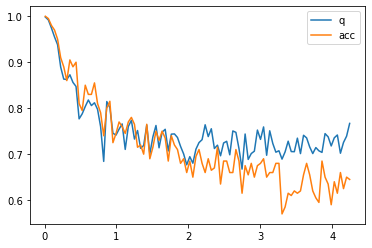

In [ ]:
n = 100
sds = np.linspace(0.01, 3 * np.sqrt(2), 100)

q_log = []
acc_log = []
for idx, sd in tqdm(enumerate(sds)):
  # data
  X, y = normal(sd, n)

  # gg
  gg = lara_graph(X, print_tqdm = False)
  scores = q_index(X, y, gg)
  q_log.append(np.mean(scores))

  # classificador
  w = [-1, 1, 1]
  w = w / np.linalg.norm(w)

  distances = []
  for i, x in enumerate(X):
      x = np.hstack((1, x))
      d = np.dot(x, w) * np.sign(y[i])
      distances.append(d)
  distances = np.array(distances)
  erro = distances < 0
  acc_log.append(1 - sum(erro) / len(erro))

plt.plot(sds, q_log, label = 'q');
plt.plot(sds, acc_log, label = 'acc');
plt.legend();

# xor

In [ ]:
def xor(sd, n):
  mean = (-1, -1)
  cov = [[sd, 0], [0, sd]]
  x1 = np.random.multivariate_normal(mean, cov, size = n)

  mean = (1, 1)
  cov = [[sd, 0], [0, sd]]
  x2 = np.random.multivariate_normal(mean, cov, size = n)

  mean = (-1, 1)
  cov = [[sd, 0], [0, sd]]
  x3 = np.random.multivariate_normal(mean, cov, size = n)

  mean = (1, -1)
  cov = [[sd, 0], [0, sd]]
  x4 = np.random.multivariate_normal(mean, cov, size = n)

  X = np.concatenate((x1, x2, x3, x4))
  y = np.array([-1] * 2 * n + [1] * 2 * n)

  return X, y

100%|██████████| 499/499 [00:06<00:00, 76.03it/s] 


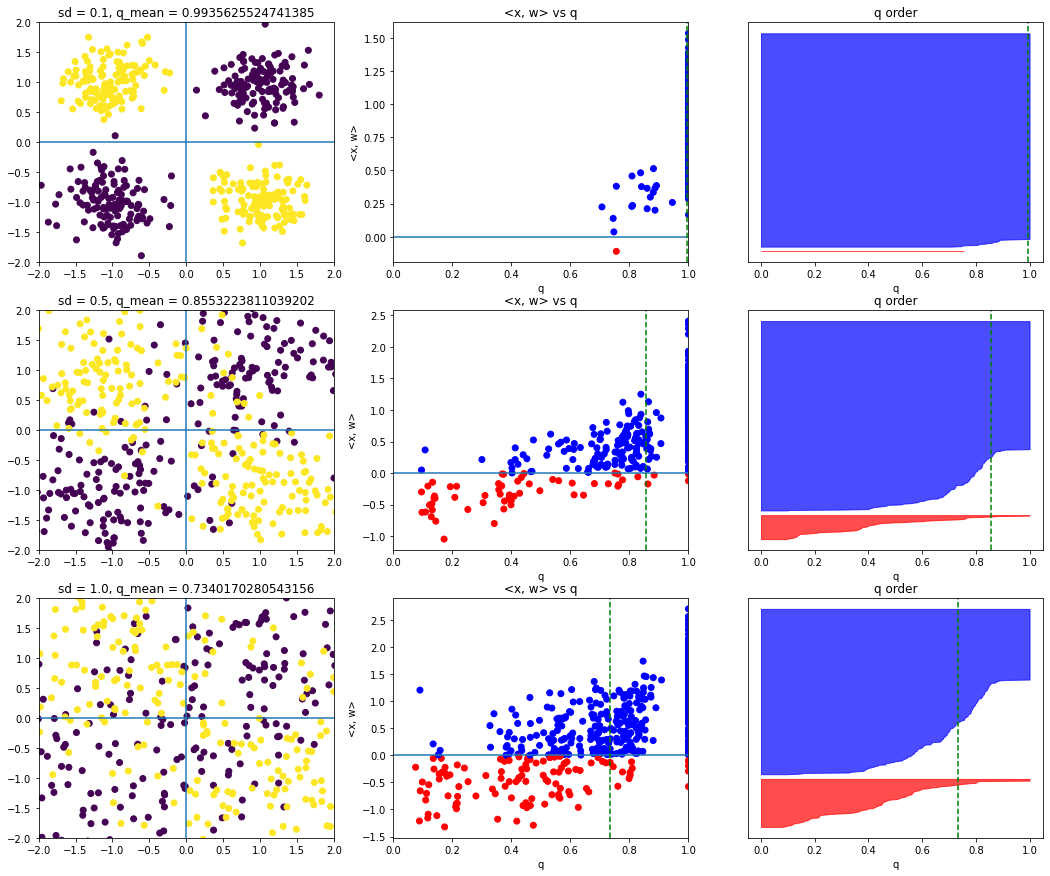

In [ ]:
n = 125
sds = [0.1, 0.5, 1.0]

fig, axis = plt.subplots(len(sds), 3, figsize = (18, 5*len(sds)))

for idx, sd in enumerate(sds):
  # data
  X, y = xor(sd, n)

  # gg
  gg = lara_graph(X)
  scores = q_index(X, y, gg)

  # classificador
  distances = []
  erro = []
  for i, x in enumerate(X):
      same = np.sign(x[0] * x[1])
      if i < 2*n:
          e = 0 if same == 1 else 1
      else:
          e = 0 if same == -1 else 1
              
      d = np.min([np.abs(x[0]), np.abs(x[1])])
      if e:
          d *= -1
      distances.append(d)
      erro.append(e)
  distances = np.array(distances)
  erro = np.array(erro)

  # plot
  axis[idx, 0].scatter(X[:, 0], X[:, 1], c = y)
  axis[idx, 0].axvline(x = 0)
  axis[idx, 0].axhline(y = 0)
  axis[idx, 0].set_xlim([-2, 2])
  axis[idx, 0].set_ylim([-2, 2])
  axis[idx, 0].set_title('sd = {}, q_mean = {}'.format(sd, np.mean(scores)));

  log = np.stack((scores, distances)).T
  colors = {0:'blue', 1:'red'}

  axis[idx, 1].scatter(log[:, 0], log[:, 1], c = [colors[e] for e in erro[:]])
  axis[idx, 1].axhline(y = 0)
  axis[idx, 1].axvline(x = np.mean(scores), color = 'green', linestyle = '--')
  axis[idx, 1].set_xlim([0, 1])
  axis[idx, 1].set_title('<x, w> vs q');
  axis[idx, 1].set_xlabel('q')
  axis[idx, 1].set_ylabel('<x, w>');

  y_lower = 10
  for c in [1, 0]:
      cluster = erro == c
      ith_cluster_silhouette_values = scores[cluster]
      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = colors[c]
      axis[idx, 2].fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )
      y_lower = y_upper + 10
  axis[idx, 2].axvline(x = np.mean(scores), color = 'green', linestyle = '--')
  axis[idx, 2].set_yticks([])
  axis[idx, 2].set_title('q order');
  axis[idx, 2].set_xlabel('q')

100it [00:35,  2.83it/s]


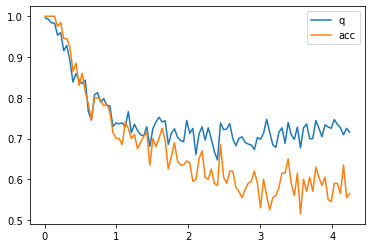

In [ ]:
n = 50
sds = np.linspace(0.01, 3 * np.sqrt(2), 100)

q_log = []
acc_log = []
for idx, sd in tqdm(enumerate(sds)):
  # data
  X, y = xor(sd, n)

  # gg
  gg = lara_graph(X, print_tqdm = False)
  scores = q_index(X, y, gg)
  q_log.append(np.mean(scores))

  # classifier
  erro = []
  for i, x in enumerate(X):
      same = np.sign(x[0] * x[1])
      if i < 2*n:
          sinal = 1
          e = 0 if same == 1 else 1
      else:
          sinal = -1
          e = 0 if same == -1 else 1
      erro.append(e)
  acc_log.append(1 - sum(erro) / len(erro))

plt.plot(sds, q_log, label = 'q');
plt.plot(sds, acc_log, label = 'acc')
plt.legend();

# circle

In [47]:
from sklearn.datasets import make_circles

100%|██████████| 499/499 [00:05<00:00, 98.28it/s] 


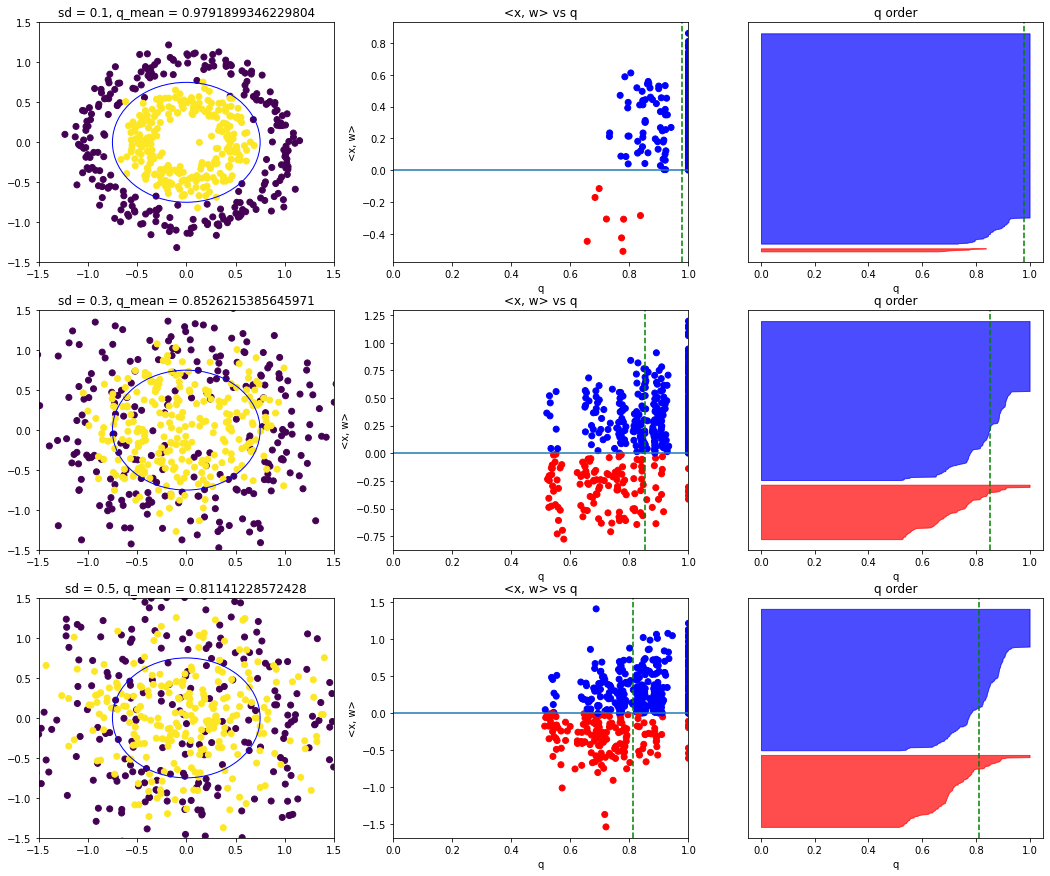

In [57]:
n = 500
sds = [0.1, 0.3, 0.5]

fig, axis = plt.subplots(len(sds), 3, figsize = (18, 5*len(sds)))

for idx, sd in enumerate(sds):
  # data
  X, y = make_circles(n_samples = n, noise = sd, factor = 0.5, shuffle = False)

  # gg
  gg = lara_graph(X)
  scores = q_index(X, y, gg)

  # classificador
  distances = []
  erro = []
  for i, x in enumerate(X):
      raio = np.linalg.norm(x)
      if i < n//2:
          e = 0 if raio > 0.75 else 1
      else:
          e = 0 if raio <= 0.75 else 1
      d = np.min([np.abs(x[0]), np.abs(x[1])])
      if e:
          d *= -1
      distances.append(d)
      erro.append(e)
  distances = np.array(distances)
  erro = np.array(erro)

  # plot
  axis[idx, 0].scatter(X[:, 0], X[:, 1], c = y)
  border = plt.Circle((0, 0), 0.75, color='blue', fill = False)
  axis[idx, 0].add_patch(border)
  axis[idx, 0].set_xlim([-1.5, 1.5])
  axis[idx, 0].set_ylim([-1.5, 1.5])
  axis[idx, 0].set_title('sd = {}, q_mean = {}'.format(sd, np.mean(scores)));

  log = np.stack((scores, distances)).T
  colors = {0:'blue', 1:'red'}

  axis[idx, 1].scatter(log[:, 0], log[:, 1], c = [colors[e] for e in erro[:]])
  axis[idx, 1].axhline(y = 0)
  axis[idx, 1].axvline(x = np.mean(scores), color = 'green', linestyle = '--')
  axis[idx, 1].set_xlim([0, 1])
  axis[idx, 1].set_title('<x, w> vs q');
  axis[idx, 1].set_xlabel('q')
  axis[idx, 1].set_ylabel('<x, w>');

  y_lower = 10
  for c in [1, 0]:
      cluster = erro == c
      ith_cluster_silhouette_values = scores[cluster]
      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = colors[c]
      axis[idx, 2].fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )
      y_lower = y_upper + 10
  axis[idx, 2].axvline(x = np.mean(scores), color = 'green', linestyle = '--')
  axis[idx, 2].set_yticks([])
  axis[idx, 2].set_title('q order');
  axis[idx, 2].set_xlabel('q')

100it [00:35,  2.84it/s]


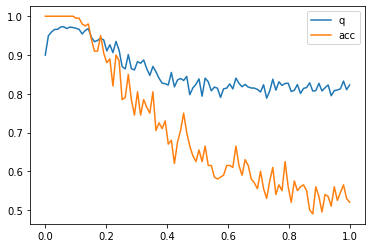

In [53]:
n = 200
sds = np.linspace(0, 1, 100)

q_log = []
acc_log = []
for idx, sd in tqdm(enumerate(sds)):
  # data
  X, y = make_circles(n_samples = n, noise = sd, factor = 0.5, shuffle = False)

  # gg
  gg = lara_graph(X, print_tqdm = False)
  scores = q_index(X, y, gg)
  q_log.append(np.mean(scores))

  # classifier
  erro = []
  for i, x in enumerate(X):
      raio = np.linalg.norm(x)
      if i < n//2:
          e = 0 if raio > 0.75 else 1
      else:
          e = 0 if raio <= 0.75 else 1
      erro.append(e)
  erro = np.array(erro)
  acc_log.append(1 - sum(erro) / len(erro))

plt.plot(sds, q_log, label = 'q');
plt.plot(sds, acc_log, label = 'acc')
plt.legend();